In [1]:
!pip install joblib pyarabic


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.8 MB/s eta 0:00:00


In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def about_model(model_name , y_test, y_pred):
    print('-------------------> ' + model_name )
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    f1 = f1_score(y_test, y_pred, average=None)
    print("F1-Score for each class:")
    class_labels = ['Positive', 'Negative']

    for i, score in enumerate(f1):
        print(f"{class_labels[i]}: {score:.2f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_labels, digits=2))

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [3]:
import os
os.chdir('/content')
current_directory = os.getcwd()
print("Current working directory:", current_directory)
contents = os.listdir()
print("Directory contents:", contents)

Current working directory: /content
Directory contents: ['.config', 'sample_data']


In [5]:
#Motassim Hamza's Cleaning Functions (dcsa project)
import json
import pandas as pd
import re
import pickle
import pyarabic.araby as araby
import pyarabic.trans as trans



# cleaning functions for dataframes
def basic_cleaning(df, target):
    """
    Basic cleaning for a DataFrame.

    Parameters:
    - df: Pandas DataFrame
    - target: Name of the column containing text data

    Returns:
    - Cleaned Pandas DataFrame
    """

    df = df.dropna(subset=[target])
    df = df[df[target] != '']
    df = df.drop_duplicates()

    return df


def encode_dataframe(df, target, mapping):
    """
    Encodes label column given a dictionary

    Parameters:
    - df: Pandas DataFrame
    - target: Column to encode
    - mapping: Dictionary contains values to decode from to

    Returns:
    - Encoded DataFrame
    """

    df[target] = df[target].map(mapping)
    return df



def remove_class(df, label, target):
    """
    Drop rows where label column contains target

    Parameters:
    - df: Pandas DataFrame
    - label: Label column
    - target: Class to remove

    Returns:
    - DataFrame without removed class
    """

    df = df[~df[label].str.contains(target)]
    return df


def remove_column(df, column):
    """
    Drops a specified column from the DataFrame.

    Parameters:
    - df: Pandas DataFrame
    - column: Name of the column to be dropped

    Returns:
    - DataFrame without removed column
    """
    return df.drop(column, axis=1, inplace=False)


def rename_columns(df, mapping):
    """
    Renames columns in the DataFrame.

    Parameters:
    - df: Pandas DataFrame
    - mapping: Dictionary specifying the old and new column names

    Returns:
    - DataFrame with renamed columns
    """
    return df.rename(columns=mapping, inplace=False)


def balance_dataframe(df, target, method, random_seed=42):
    """
    Balence the dataframe by [under-sampling the majority/oversampling the minority] class

    Parameters:
    - df: Pandas DataFrame
    - target: Name of the target column to balance
    - method: Balancing method ('over or 1', 'under or -1')
    - random_seed: Random seed for reproducibility

    Returns:
    - Balanced Pandas DataFrame
    """


    # Find the class with the minimum / maximum number of samples
    minority_class = df[target].value_counts().idxmin()
    majority_class = df[target].value_counts().idxmax()

    # Separate the DataFrame into two based on the target class
    df_minority = df[df[target] == minority_class]
    df_majority = df[df[target] == majority_class]

    if method == 'over' or method == 1:
        # randomly duplicating rows
        oversample_factor = int(len(df_majority) / len(df_minority))
        df_minority_resampled = pd.concat([df_minority] * oversample_factor, ignore_index=True)
        df_balanced = pd.concat([df_majority, df_minority_resampled], ignore_index=True)
    elif method == 'under' or method == -1:
        # randomly removing rows
        under_sample_size = min(len(df_minority), len(df_majority))
        df_majority_undersampled = df_majority.sample(n=under_sample_size, random_state=random_seed)
        df_balanced = pd.concat([df_majority_undersampled, df_minority], ignore_index=True)
    else:
        raise ValueError("Invalid balancing method. Use 'over/1' or 'under/-1'")

    return df_balanced

# cleaning functions for text data
def create_emoji_mapping(df):
    """
    Create a mapping dictionary from a DataFrame containing emojis and labels.

    Parameters:
    - df: DataFrame with 'Emoji' and 'Label' columns

    Returns:
    - Dictionary mapping emojis to labels
    """
    emoji_mapping = dict(zip(df['emoji'], df['text']))
    return emoji_mapping

def translate_emoji(text, emoji_mapping):
    """
    Replace emojis in a given text with their corresponding labels based on a mapping dictionary.

    Parameters:
    - text: Input text
    - emoji_mapping: Dictionary mapping emojis to labels

    Returns:
    - Text with emojis replaced by labels
    """
    for emoji_char, label in emoji_mapping.items():
        text = text.replace(emoji_char, ' '+label+' ')

    return text


def normalize_hashtags(text):
    """
     hashtags processing by removing hashtag and replacing underscore '_' by space ' ' in order to keep the words

    Parameters:
    - text: Input text

    Returns:
    - Cleaned text
    """
    hashtag_pattern = re.compile(r'#(\w+)')
    matches = hashtag_pattern.findall(text)
    for match in matches:
        original_hashtag = '#' + match
        transformed_text = match.replace('_', ' ')
        text = text.replace(original_hashtag, transformed_text)

    return text



def clean_text(text):
    """
     text processing steps version 1, including removing URLs, translating emojis,
     normalizing digits, keeping only Arabic characters, removing extra whitespaces,
     and cleaning up various Arabic text features.

    Parameters:
    - text: Input text

    Returns:
    - Cleaned text
    """

    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE) # remove URLs
    text = translate_emoji(text, emoji_mapping) # emojis to arabic ❤️ to قلب أحمر
    text = trans.normalize_digits(text, source='all', out='west') # Eastern/Persian numbers to Weastern numbers : ۰۱۲۳۴۵۶۷۸۹ ٠١٢٣٤٥٦٧٨٩ to 123456789
    text = normalize_hashtags(text) # في_المزيد# to في المزيد
    text = re.sub(r'\s?@\w+\s?', ' ', text) # remove tags like @user
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", text) # keep only Arabic characters
    text = araby.strip_tashkeel(text) # remove arabic tashkeel : الْعَرَبِيّةُ
    text = araby.strip_diacritics(text) # remove arabic decorations : الرّحمٰن
    text = araby.strip_tatweel(text) # remove arabic tatweel : العـــــربية
    text = re.sub(r"(.)\1+", r"\1", text) #remove repeated chars : مممممملفففف to ملف
    text = ''.join([char for char in text if char not in ['،', '؛', '؟']]) # remove specific arabic punctuation marks like '،', '؛', '؟'
    text = re.sub(r"\s+", " ", text).strip() # remove extra whitespaces

    return text

def derrej(text):
    """
    Replace English letters with their corresponding Arabic letters

    Parameters:
    - text: Text written in english letters

    Returns:
    - Text written in Arabic letters
    """

    english_arabic_mapping = {
        'a': 'ا',
        'b': 'ب',
        'c': 'س',
        'd': 'د',
        'e': '',
        'f': 'ف',
        'g': 'ج',
        'h': 'ه',
        'i': 'ي',
        'j': 'ج',
        'k': 'ك',
        'l': 'ل',
        'm': 'م',
        'n': 'ن',
        'o': 'و',
        'p': 'ب',
        'q': 'ق',
        'r': 'ر',
        's': 'س',
        't': 'ت',
        'u': 'ي',
        'v': 'ف',
        'w': 'و',
        'x': 'خ',
        'y': 'ي',
        'z': 'ز',
        'T': 'ط',
        'S': 'ص',
        'D': 'ض',
        'kh': 'خ',
        'ch': 'ش',
        'gh': 'غ',
        'ou': 'و',
        '3': 'ع',
        '7': 'ح',
        '9': 'ق',
        '8': 'ه',
        '2': 'ء',
        '5': 'خ',
        '4': 'غ',
    }

    # Replace English letters with Arabic letters
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'\d{3,}', '', text) # remove numbers to not confuse with letters
    arabic_text = ''
    i = 0
    while i < len(text):
        char = text[i]
        if i < len(text) - 1 and (char + text[i + 1]) in english_arabic_mapping:
            arabic_text += english_arabic_mapping[char + text[i + 1]]
            i += 2
        else:
            arabic_text += english_arabic_mapping.get(char, char)
            i += 1

    return arabic_text


def detect_text_lang(text, threshold=0.85):
    """
    Detect whether the text is written in arabic or english letters,
    Remove all numbers, whitespaces, and special chararachters,
    then Replace English letters with their corresponding Arabic letters,
    if English letters pourcentage is more than a threshold

    Parameters:
    - text: Text written in english letters
    - threshold: float pourcentage of

    Returns:
    - -1 if English, 1 if Arabic, 0 if Mixed
    """
    arabic_letters = set("ابتثجحخدذرزسشصضطظعغفقكلمنهويءآأإئىة")
    english_letters = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")

    text = ''.join(char for char in text if char.isalpha())
    total_chars = len(text)
    arabic_count = sum(1 for char in text if char in arabic_letters)
    english_count = sum(1 for char in text if char in english_letters)

    arabic_percentage = arabic_count / total_chars
    english_percentage = english_count / total_chars

    if arabic_percentage > threshold:
        return 1
    elif english_percentage > threshold:
        return -1
    else:
        return 0


def stop_words_removal(line, all_stop_words):
    """
    Removes Stop Words in a tokenized senetnce

    Parameters:
    - line: list of words

    Returns:
    - list of words without Stop Words
    """
    return line.remove(all_stop_words)


def get_stop_words(file_path):
    """
    Get a list of stop words from a txt file

    Parameters:
    - file_path: path to the json file

    Returns:
    - list of stop words
    """
    with open(file_path, 'r') as file:
        all_stop_words = json.load(file)
    return all_stop_words


def stemmed_comment(comment, stemmer, all_stop_words):
    """
    Stem a comment using a stemmer

    Parameters:
    - comment: comment to stem
    - stemmer: stemmer to use
    - all_stop_words: list of stop words to remove

    Returns:
    - stemmed comment
    """
    return " ".join([word for word in araby.tokenize(stemmer.stem(comment)) if word not in all_stop_words])

"""
Ignore this part, already done in the preprocessing

"""
# def get_doda_sw(category, theme, sense_words=[]):
#   """
#     Create a list of stop words from a theme from a category using doda api,
#     Except a list of words that may have sense

#     Parameters:
#     - category: category to get theme from
#     - theme: theme to get darija words from
#     - sense_words: words to ignore, default nothing []

#     Returns:
#     - list of stop words from the specific theme
#     """
#   sw = [Category(category, theme).get_darija_variations(x) for x in Category(category, theme).get_english_words()]
#   sw = [derrej(value) if isinstance(value, str) else value for word_variations in sw for value in word_variations.values()]
#   sw = [item for item in sw if item not in sense_words]
#   sw = list(filter(None, set(sw)))
#   sw = [clean_text(item) for item in sw]
#   return sw

emoji_mapping = create_emoji_mapping(pd.read_csv("emojis.csv"))
all_stopwords = get_stop_words("all_stop_words.json")

In [7]:
#loading the dcsa model and vectorizer
import os
import joblib


model_path = "dcsa-x.joblib"
model = joblib.load(model_path)

#depends
emoji_mapping = create_emoji_mapping(pd.read_csv("emojis.csv"))
all_stopwords = get_stop_words("all_stop_words.json")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.2.2 when using version 1.6.0. This might lead to breaking code o

In [8]:
#this test  data is the  same  used to evaluate my svm model
df = pd.read_csv("test_data.csv")

In [9]:
df.head()

,text,text_cleaned,target
0,شكون جاي يشوف غييا واش رجعات يحط لايك 😊🌙,غيا لايك يحط باسمتين بعينين رجع,1
1,أنودوو تقودوو ونتوما باغين تنودوو غي لفتناا بق...,انودو لفت تنودو منافقين تقودو تقاو حادين ونتوم...,0
2,خص ليحويه هوا ياها راس الطارو كاع مفهم كرو,ليحويه ياها هوا طارو كرو مفهم,0
3,أصلا الدولة هادشي الي بغات، العري و الفسق و ا...,افدل مفتونين فسق عر فاسقا شادا شدود خرج غير,0
4,المغاربة استرجعوا الصحراء من الاسبان نفسهم ولي...,دراع تبون وعسابته استرجعوا,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6765 entries, 0 to 6764
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          6765 non-null   object
 1   text_cleaned  6765 non-null   object
 2   target        6765 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 158.7+ KB


In [12]:
#applaying the cleaning to the  text colmn
df["hamza_cleaned_text"] = df["text"].apply(clean_text)

In [13]:
df.head()

,text,text_cleaned,target,hamza_cleaned_text
0,شكون جاي يشوف غييا واش رجعات يحط لايك 😊🌙,غيا لايك يحط باسمتين بعينين رجع,1,شكون جاي يشوف غيا واش رجعات يحط لايك وجه مبتسم...
1,أنودوو تقودوو ونتوما باغين تنودوو غي لفتناا بق...,انودو لفت تنودو منافقين تقودو تقاو حادين ونتوم...,0,أنودو تقودو ونتوما باغين تنودو غي لفتنا بقاو ح...
2,خص ليحويه هوا ياها راس الطارو كاع مفهم كرو,ليحويه ياها هوا طارو كرو مفهم,0,خص ليحويه هوا ياها راس الطارو كاع مفهم كرو
3,أصلا الدولة هادشي الي بغات، العري و الفسق و ا...,افدل مفتونين فسق عر فاسقا شادا شدود خرج غير,0,أصلا الدولة هادشي الي بغات العري و الفسق و الش...
4,المغاربة استرجعوا الصحراء من الاسبان نفسهم ولي...,دراع تبون وعسابته استرجعوا,1,المغاربة استرجعوا الصحراء من الاسبان نفسهم ولي...


In [14]:
df.isna().sum()
df.dropna(inplace=True)

In [15]:
df.isna().sum()


,0
text,0
text_cleaned,0
target,0
hamza_cleaned_text,0


In [16]:
#in my case i worked : pos = 1 , neg = 0 , whereas Hamza does the opposite
df['target'] = df['target'].replace({1: 0, 0: 1})

In [17]:
hamza_predict = model.predict(df["hamza_cleaned_text"])


-------------------> Hamza Model
Accuracy: 0.74
F1-Score for each class:
Positive: 0.73
Negative: 0.75

Classification Report:
              precision    recall  f1-score   support

    Positive       0.74      0.72      0.73      3322
    Negative       0.74      0.76      0.75      3443

    accuracy                           0.74      6765
   macro avg       0.74      0.74      0.74      6765
weighted avg       0.74      0.74      0.74      6765



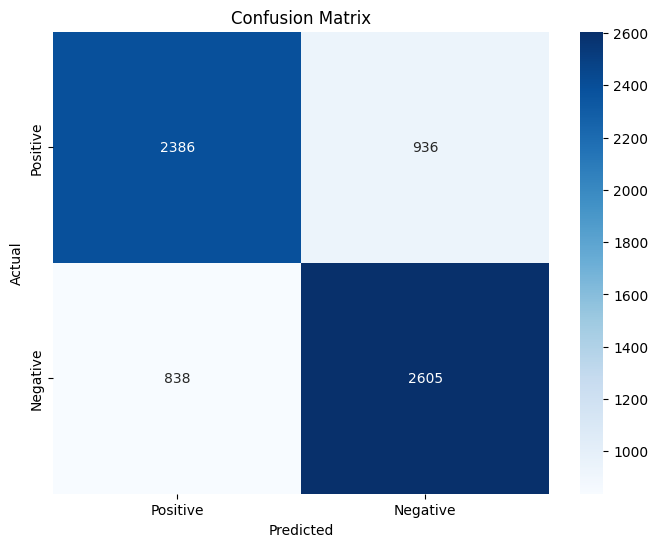

In [19]:
about_model("Hamza Model" , df["target"], hamza_predict)